In [1]:
import pickle
import os
from glob import glob

import imutils
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

## Generate Tags

In [3]:
tags = {}

for filepath in glob('data/*.txt'):
    filename = os.path.basename(filepath).replace('.txt', '')
    classification = eval(filename.split('_')[0])
    
    img_name = filename.split('_')[1]
    tags[img_name] = classification

## Generate Metadata

In [13]:
meta = {}

for filepath in glob('data/*.pkl'):
    filename = os.path.basename(filepath).replace('.pkl', '')
    data = pickle.load(open(filepath, 'rb'))
    
    classification = True if filename.split('_')[0] == 'occupied' else False
    
    img_name = filename.split('_')[1]
    meta[img_name] = {}
    meta[img_name]['pred'] = classification
    meta[img_name]['actual'] = tags.get(img_name, False)
    meta[img_name]['pir_5'] = np.mean(data['pir'][-5:])
    meta[img_name]['pir_10'] = np.mean(data['pir'][-10:])
    meta[img_name]['pir_20'] = np.mean(data['pir'][-20:])
    meta[img_name]['pir_30'] = np.mean(data['pir'][-30:])
    meta[img_name]['pir_100'] = np.mean(data['pir'][-100:])
    

## Calculate Rolling Averages of PIR Sensor Values

In [17]:
pd_data = {
    'img_name': [],
    'pred': [],
    'actual': [],
    'pir_5': [],
    'pir_10': [],
    'pir_20': [],
    'pir_30': [],
    'pir_100': []
}
for img_name, data in meta.items():
    pd_data['img_name'].append(img_name)
    for key, value in data.items():
        pd_data[key].append(value)

In [18]:
df = pd.DataFrame(pd_data)

In [19]:
print (df.shape)
df.head()

(1220, 8)


,img_name,pred,actual,pir_5,pir_10,pir_20,pir_30,pir_100
0,2018-10-30-17-02-08.106033,False,False,0.0,0.0,0.0,0.0,0.24
1,2018-10-30-10-58-39.388892,False,False,0.0,0.0,0.0,0.0,0.00
2,2018-10-30-08-48-29.191265,False,False,0.0,0.0,0.0,0.0,0.26
3,2018-10-30-20-25-55.820775,True,True,0.0,0.0,0.0,0.0,0.00
4,2018-10-29-19-28-07.691267,False,False,0.0,0.0,0.0,0.0,0.00


In [20]:
df.groupby(['pred', 'actual']).pir_10.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,False,False,0.048791,1158
1,True,False,0.342308,26
2,True,True,0.444444,36


In [23]:
df.groupby(['pred', 'actual']).pir_20.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,False,False,0.054706,1158
1,True,False,0.288462,26
2,True,True,0.386111,36


In [45]:
df.to_csv('data.csv', index=False)

## Reducing False Positives with a Pre-Trained Model

In [23]:
# Load Model
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
	"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
	"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
	"sofa", "train", "tvmonitor"]
net = cv2.dnn.readNetFromCaffe('MobileNetSSD_deploy.prototxt.txt', 'MobileNetSSD_deploy.caffemodel')

In [24]:
image = oth_data['frame']

NameError: name 'oth_data' is not defined

In [25]:
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 0.007843, (300, 300), 127.5)

NameError: name 'image' is not defined

In [111]:
net.setInput(blob)
detections = net.forward()

In [112]:
detections.shape

(1, 1, 1, 7)

In [113]:
# loop through each class prediction
for i in np.arange(0, detections.shape[2]):
#     print (i)
    class_prob = detections[0, 0, i, 2]
    class_idx = int(detections[0, 0, i, 1])

In [114]:
person_prob = max([detections[0, 0, i, 2] if int(detections[0, 0, i, 1]) == 15 else 0 for i in np.arange(0, detections.shape[2])])

In [26]:
def get_person_prob(image):
    resized = cv2.resize(image, (300, 300))
    blob = cv2.dnn.blobFromImage(resized, 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    probs = [
        detections[0, 0, i, 2] if int(detections[0, 0, i, 1]) == 15 else 0 
        for i in np.arange(0, detections.shape[2])
    ]
    person_prob = max(probs)
    return person_prob

In [154]:
# initialize the HOG descriptor/person detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [141]:
meta = {}

for filepath in glob('data/*.pkl'):
    filename = os.path.basename(filepath).replace('.pkl', '')
    data = pickle.load(open(filepath, 'rb'))
    
    classification = True if filename.split('_')[0] == 'occupied' else False
    
    img_name = filename.split('_')[1]
    meta[img_name] = {}
    meta[img_name]['pred'] = classification
    meta[img_name]['actual'] = tags.get(img_name, False)
    
    meta[img_name]['model_score'] = get_person_prob(data['frame'])    

In [144]:
pd_data = {
    'img_name': [],
    'pred': [],
    'actual': [],
    'model_score': []
}
for img_name, data in meta.items():
    pd_data['img_name'].append(img_name)
    for key, value in data.items():
        pd_data[key].append(value)
        
df = pd.DataFrame(pd_data)

In [146]:
df.groupby(['pred', 'actual']).model_score.agg({'mean': 'mean', 'cnt': 'count'}).reset_index()

/Users/ianwhitestone/miniconda3/envs/rpi/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,pred,actual,mean,cnt
0,False,False,0.001362,1158
1,True,False,0.090941,27
2,True,True,0.332430,36


In [147]:
df[(df.pred == True) & (df.actual == True)]

,img_name,pred,actual,model_score
3,2018-10-30-20-25-55.820775,True,True,0.000000
11,2018-11-01-11-54-45.388408,True,True,0.000000
22,2018-10-29-22-26-03.432572,True,True,0.503364
51,2018-10-29-21-40-52.736933,True,True,0.000000
138,2018-10-31-23-04-28.827276,True,True,0.000000
142,2018-10-29-19-20-24.896117,True,True,0.923769
157,2018-11-01-11-45-37.394912,True,True,0.000000
270,2018-11-01-19-45-53.951334,True,True,0.000000
279,2018-10-31-07-47-56.922646,True,True,0.000000
303,2018-10-28-21-40-26.350847,True,True,0.536695


## Comparing Model Runtimes

In [140]:
# %timeit -n 10 get_person_prob(oth_data['frame'])

%time [get_person_prob(oth_data['frame']) for x in range(0, 10)]

CPU times: user 1.41 s, sys: 25.6 ms, total: 1.43 s
Wall time: 598 ms


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Inspecting Some Files

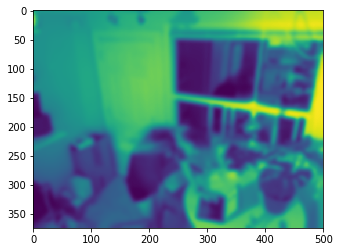

In [4]:
# sample_data = pickle.load(open('data/occupied_2018-10-30-11-31-10.910477.pkl', 'rb'))
sample_data = pickle.load(open('sample.pkl', 'rb'))
frame = sample_data['frames'][-1]
plt.imshow(frame)

# for frame in sample_data['frames']:
#     print(get_person_prob(frame))

In [8]:
sample_data['frames'][-1]

In [24]:
tp_pkl_file = open('tp_example.pkl', 'rb')
fp_pkl_file = open('fp_example.pkl', 'rb')
oth_pkl_file = open('data/occupied_2018-11-02-23-08-31.498366.pkl', 'rb')

tp_data = pickle.load(tp_pkl_file)
fp_data = pickle.load(fp_pkl_file)
oth_data = pickle.load(oth_pkl_file)

In [14]:
print (np.mean(tp_data['pir']))
print (np.mean(tp_data['pir'][-10:]))

0.04
1.0


In [15]:
print (np.mean(fp_data['pir']))
print (np.mean(fp_data['pir'][-10:]))

0.0
0.0


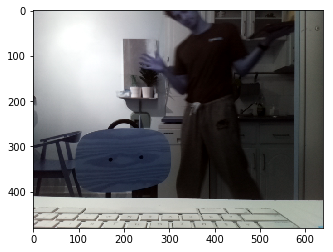

In [23]:
plt.imshow(tp_data['frame'])

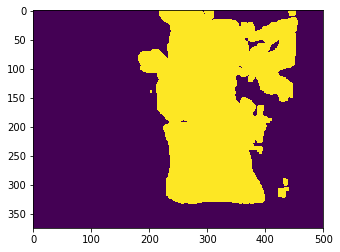

In [25]:
plt.imshow(tp_data['frame_delta'])

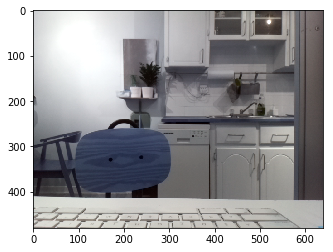

In [26]:
plt.imshow(fp_data['frame'])

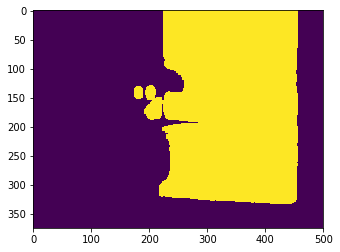

In [27]:
plt.imshow(fp_data['frame_delta'])

plt.imshow(oth_data['frame'])

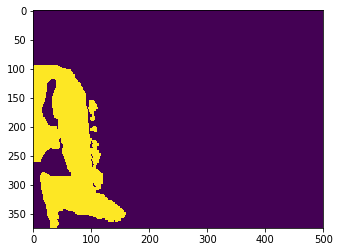

In [26]:
plt.imshow(oth_data['frame_delta'])

In [31]:
cv2.imwrite('oth.jpg', oth_data['frame'])

True

## Background Substraction Demo

In [127]:
frame1 = cv2.imread('background.png')
frame2 = cv2.imread('person.png')

In [128]:
frame = imutils.resize(frame1, height=270)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
avg = cv2.GaussianBlur(gray, (21, 21), 0).astype("float")
avg = np.insert(avg, 499, 60, axis=1)

In [129]:
frame = imutils.resize(frame2, height=270)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (21, 21), 0)


frame_delta = cv2.absdiff(gray_blur, cv2.convertScaleAbs(avg))

thresh = cv2.threshold(frame_delta, 5, 255, cv2.THRESH_BINARY)[1]
dilated = cv2.dilate(thresh, None, iterations=2)
contours = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)


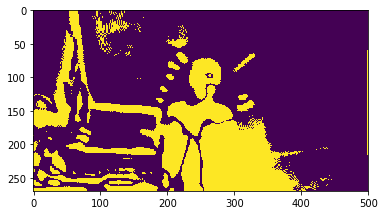

In [135]:
plt.imshow(thresh)

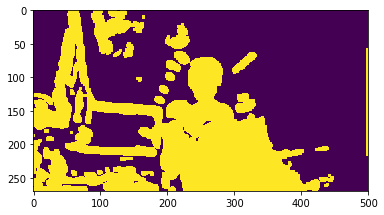

In [131]:
plt.imshow(dilated)

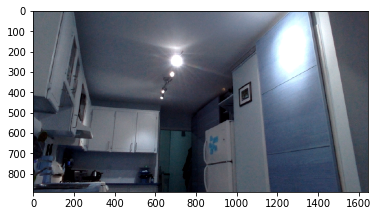

In [132]:
plt.imshow(frame1)

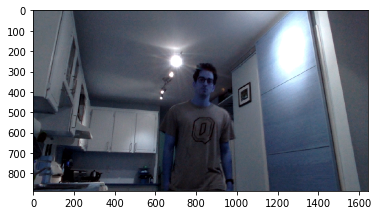

In [133]:
plt.imshow(frame2)